In [28]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Subject enrolments at Scottish Universities in 2019/2020

Investigating the proportion of females enrolling at Undergraduate and Postgraduate <i>and</i> full-time and part-time courses at Scottish Universities in 2019/2020. There will be a focus on female enrolment in Computing subjects compared to other subjects at the different levels and modes.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import janitor
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

%matplotlib inline

print("Importing libraries successful.")

Importing libraries successful.


In [3]:
# Customisations for plotting
male_color = "#48c9b0"
female_color = "#9400d3"
other_color = "#00b6ff"

ticks_size = 12

print("Color used to indicate males: ", male_color)
print("Color used to indicate females: ", female_color)
print("Color used to indicate other: ", other_color)

Color used to indicate males:  #48c9b0
Color used to indicate females:  #9400d3
Color used to indicate other:  #00b6ff


<hr style="height:2.5px;background-color:darkviolet"></hr>

## Analysis of 2019/2020 academic year

### Import 2019/2020 dataset

This dataset contains a breakdown of student enrolment by subject, level of study, mode of study, country of the HE provider, and sex for academic year 2019/2020.  
Data was obtained from <a href="https://www.hesa.ac.uk/">HESA</a> and a copy is uploaded to GitHub.

In [4]:
# Path to data in Github
url = r"https://github.com/kjp07/Women-In-STEM/blob/main/data/2019-2020.csv?raw=true"

# Import 2019-2020 dataset
df_19 = pd.read_csv(url, header=14)
df_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32944 entries, 0 to 32943
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CAH level 1             32944 non-null  object
 1   First year marker       32944 non-null  object
 2   Level of study          32944 non-null  object
 3   Mode of study           32944 non-null  object
 4   Country of HE provider  32944 non-null  object
 5   Sex                     32944 non-null  object
 6   Academic Year           32944 non-null  object
 7   Number                  32944 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 2.0+ MB


In [5]:
df_19.head()

,CAH level 1,First year marker,Level of study,Mode of study,Country of HE provider,Sex,Academic Year,Number
0,01 Medicine and dentistry,All,All,All,All,Female,2019/20,42610
1,01 Medicine and dentistry,All,All,All,All,Male,2019/20,27605
2,01 Medicine and dentistry,All,All,All,All,Other,2019/20,150
3,01 Medicine and dentistry,All,All,All,All,Total,2019/20,70370
4,01 Medicine and dentistry,All,All,Full-time,All,Female,2019/20,36470


In [6]:
# View unique values in each column to see what can be filtered
print(df_19["CAH level 1"].unique())
print(df_19["First year marker"].unique())
print(df_19["Level of study"].unique())
print(df_19["Mode of study"].unique())
print(df_19["Country of HE provider"].unique())

['01 Medicine and dentistry' '02 Subjects allied to medicine'
 '03 Biological and sport sciences' '04 Psychology'
 '05 Veterinary sciences' '06 Agriculture, food and related studies'
 '07 Physical sciences' '08 General and others in sciences'
 '09 Mathematical sciences' '10 Engineering and technology' '11 Computing'
 '12 Geographical and environmental studies (natural sciences)'
 '13 Architecture, building and planning' 'Total science CAH level 1'
 '12 Geographical and environmental studies (social sciences)'
 '14 Humanities and liberal arts (non-specific)' '15 Social sciences'
 '16 Law' '17 Business and management' '18 Communications and media'
 '19 Language and area studies'
 '20 Historical, philosophical and religious studies'
 '21 Creative arts and design' '22 Education and teaching'
 '23 Combined and general studies' 'Total non-science CAH level 1' 'Total']
['All' 'First year' 'Other years']
['All' 'Postgraduate (research)' 'Postgraduate (taught)'
 'All postgraduate' 'First degree

### Cleaning and prep

In [7]:
# Headers to snakecase
df_19_clean = df_19.clean_names()

In [8]:
# Drop total rows (Total - Science subject areas, Total - Non-science subject areas, Total)
df_19_clean = df_19_clean[(df_19_clean["cah_level_1"] != "Total") 
                                & (df_19_clean["cah_level_1"] != "Total science CAH level 1")
                                & (df_19_clean["cah_level_1"] != "Total non-science CAH level 1")
                                & (df_19_clean["cah_level_1"] != "Combined and general studies")].copy()

In [9]:
# Remove the brackets and number/letter at the start of the Subject Area values
df_19_clean["cah_level_1"] = df_19_clean["cah_level_1"].str[3:]
subjects_19_20 = df_19_clean["cah_level_1"].unique()
print(df_19_clean["cah_level_1"].unique())

['Medicine and dentistry' 'Subjects allied to medicine'
 'Biological and sport sciences' 'Psychology' 'Veterinary sciences'
 'Agriculture, food and related studies' 'Physical sciences'
 'General and others in sciences' 'Mathematical sciences'
 'Engineering and technology' 'Computing'
 'Geographical and environmental studies (natural sciences)'
 'Architecture, building and planning'
 'Geographical and environmental studies (social sciences)'
 'Humanities and liberal arts (non-specific)' 'Social sciences' 'Law'
 'Business and management' 'Communications and media'
 'Language and area studies'
 'Historical, philosophical and religious studies'
 'Creative arts and design' 'Education and teaching'
 'Combined and general studies']


<hr style="height:2.5px;background-color:darkviolet"></hr>

### Enrolment in full-time undergraduate subjects at Scottish Universities in 2019-2020

In [10]:
# Filter for Scotland, Undergraduate level of study, and full-time study
ft_ug_scotland_19 = df_19_clean[(df_19_clean["first_year_marker"] == "First year")
                     & (df_19_clean["country_of_he_provider"] == "Scotland")
                     & (df_19_clean["level_of_study"] == "All undergraduate")
                     & (df_19_clean["mode_of_study"] == "Full-time")].copy()

In [11]:
# Full time, UG subjects
pivot = pd.pivot_table(ft_ug_scotland_19, values="number", index="cah_level_1", columns="sex").reset_index()
pivot.sort_values(by="Female", ascending=False, inplace=True)

# Percentage of female
pivot["% Female"] = round((pivot["Female"] / pivot["Total"]) * 100, 2)
pivot.sort_values(by="% Female", ascending=False, inplace=True)

# Add color gradient
cm = sns.diverging_palette(20, 235, n=100, center="light", as_cmap=True)
pivot.style.background_gradient(cmap=cm, subset=["% Female"])

sex,cah_level_1,Female,Male,Other,Total,% Female
23,Veterinary sciences,370,50,0,415,89.160000
8,Education and teaching,1055,200,0,1255,84.060000
22,Subjects allied to medicine,5400,1035,5,6435,83.920000
20,Psychology,1415,350,5,1770,79.940000
15,Language and area studies,1700,565,5,2275,74.730000
21,Social sciences,3180,1450,0,4635,68.610000
18,Medicine and dentistry,1015,520,0,1535,66.120000
7,Creative arts and design,2030,1030,10,3075,66.020000
16,Law,1150,620,0,1770,64.970000
0,"Agriculture, food and related studies",500,275,5,780,64.100000


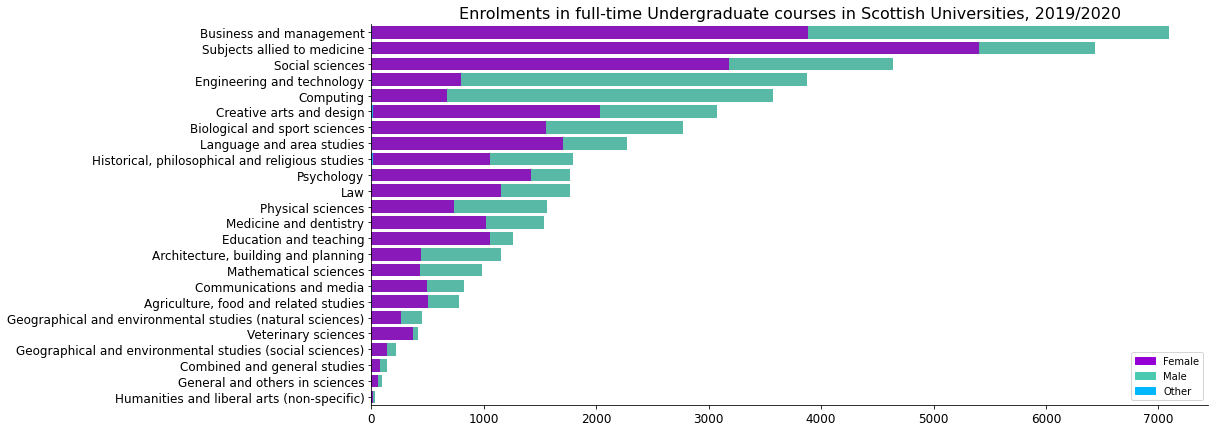

In [12]:
# Get subject list ordered by student enrolment
sort_ix = pivot.sort_values(by="Total", ascending = False)["cah_level_1"].unique()

# Plot actual numbers of enrolment
plt.figure(figsize=(15,7))
t = sns.barplot(x="Total", y="cah_level_1", order = sort_ix, palette=[male_color], data=pivot)
f = sns.barplot(x="Female", y="cah_level_1", order = sort_ix, palette=[female_color], data=pivot)
o = sns.barplot(x="Other", y="cah_level_1", order = sort_ix, palette=[other_color], data=pivot)

# add legend
male_bar = mpatches.Patch(color=male_color, label='Male')
female_bar = mpatches.Patch(color=female_color, label='Female')
other_bar = mpatches.Patch(color=other_color, label='Other')
plt.legend(handles=[female_bar, male_bar, other_bar], loc='lower right')

plt.title("Enrolments in full-time Undergraduate courses in Scottish Universities, 2019/2020", size=16)
plt.ylabel("")
plt.xlabel("")
plt.yticks(size=ticks_size)
plt.xticks(size=ticks_size)
sns.despine()
plt.show()

In [13]:
# Filter out "Total"
ft_ug_scotland_19_f_m_o = ft_ug_scotland_19[(ft_ug_scotland_19["sex"] != "Total")].copy()

# Calculate percentages of female enrolment per subject
total = ft_ug_scotland_19_f_m_o.groupby('cah_level_1')['number'].sum().reset_index()
female = ft_ug_scotland_19_f_m_o[ft_ug_scotland_19_f_m_o["sex"] =='Female'].groupby('cah_level_1')['number'].sum().reset_index()
other = ft_ug_scotland_19_f_m_o[ft_ug_scotland_19_f_m_o["sex"] == 'Other'].groupby('cah_level_1')['number'].sum().reset_index()

female['number'] = [i / j * 100 for i,j in zip(female['number'], total['number'])]
other['number'] = [i / j * 100 for i,j in zip(other['number'], total['number'])]
total['number'] = [i / j * 100 for i,j in zip(total['number'], total['number'])]
female.sort_values(by="number", ascending=False, inplace=True)
order_ug_ft = female["cah_level_1"]

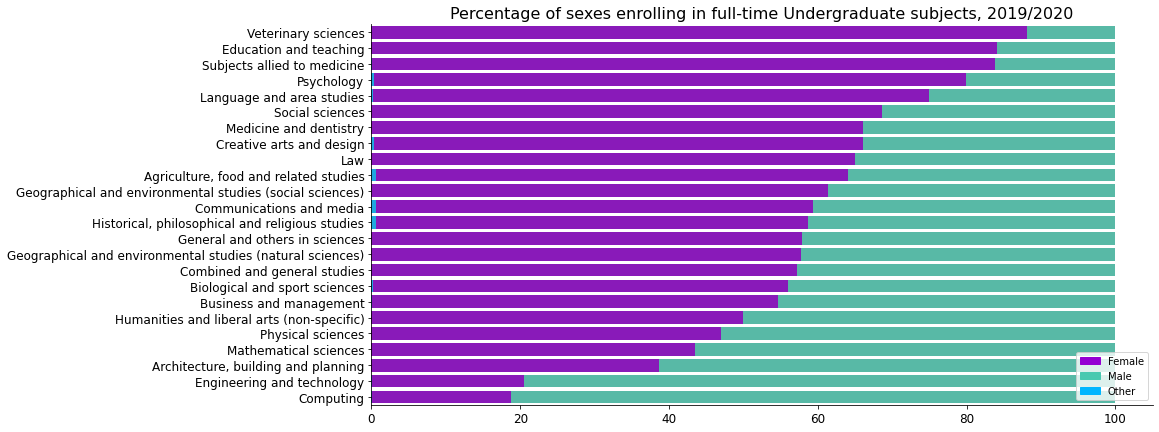

In [14]:
# set the figure size
plt.figure(figsize=(14, 7))

# bar chart 1 -> top bars (group of 'males')
bar1 = sns.barplot(x="number",  y="cah_level_1", data=total, order=female["cah_level_1"], color=male_color)

# bar chart 3 -> middle bars (group of 'females')
bar3 = sns.barplot(x="number", y="cah_level_1", data=female, order=female["cah_level_1"], color=female_color)

# bar chart 3 -> bottom bars (group of 'other')
bar2 = sns.barplot(x="number", y="cah_level_1", data=other, order=female["cah_level_1"], color=other_color)

# add legend
male_bar = mpatches.Patch(color=male_color, label='Male')
female_bar = mpatches.Patch(color=female_color, label='Female')
other_bar = mpatches.Patch(color=other_color, label='Other')
plt.legend(handles=[female_bar, male_bar, other_bar], loc='lower right')

# show the graph
plt.title("Percentage of sexes enrolling in full-time Undergraduate subjects, 2019/2020", size=16)
plt.xlabel("")
plt.xticks(size=ticks_size)
plt.ylabel("")
plt.yticks(size=ticks_size)
sns.despine()
plt.show()

### Analysis

Computing has the fifth largest number in enrolments, behind Engineering and techonology (4), Social sciences (3), Subjects allied to medicine (2), and Business and management (1). Despite this, females only make up 18.77% of total enrolments in Computing. Similarly, only 20.54% of students enrolling in Engineering and techonology were female.

<hr style="height:2.5px;background-color:darkviolet"></hr>

### Enrolment in part-time undergraduate subjects at Scottish Universities in 2019-2020

In [15]:
# Filter for Scotland, Undergraduate level of study, and full-time study
pt_ug_scotland_19 = df_19_clean[(df_19_clean["first_year_marker"] == "First year")
                     & (df_19_clean["country_of_he_provider"] == "Scotland")
                     & (df_19_clean["level_of_study"] == "All undergraduate")
                     & (df_19_clean["mode_of_study"] == "Part-time")].copy()

In [16]:
# Part-time, UG subjects
ug_pt = pd.pivot_table(pt_ug_scotland_19, values="number", index="cah_level_1", columns="sex").reset_index()
ug_pt.sort_values(by="Female", ascending=False, inplace=True)

# Percentage of female
ug_pt["% Female"] = round((ug_pt["Female"] / ug_pt["Total"]) * 100, 2)
ug_pt.sort_values(by="% Female", ascending=False, inplace=True)

# Add color gradient
cm = sns.diverging_palette(20, 235, n=100, center="light", as_cmap=True)
ug_pt.style.background_gradient(cmap=cm, subset=["% Female"])

sex,cah_level_1,Female,Male,Other,Total,% Female
12,Geographical and environmental studies (social sciences),5,0,0,5,100.000000
23,Veterinary sciences,20,0,0,20,100.000000
22,Subjects allied to medicine,2360,330,5,2695,87.570000
21,Social sciences,1245,230,15,1490,83.560000
8,Education and teaching,950,285,20,1255,75.700000
20,Psychology,875,265,50,1190,73.530000
14,Humanities and liberal arts (non-specific),480,225,0,705,68.090000
16,Law,160,75,0,235,68.090000
4,Combined and general studies,1910,1105,0,3010,63.460000
11,Geographical and environmental studies (natural sciences),115,85,0,195,58.970000


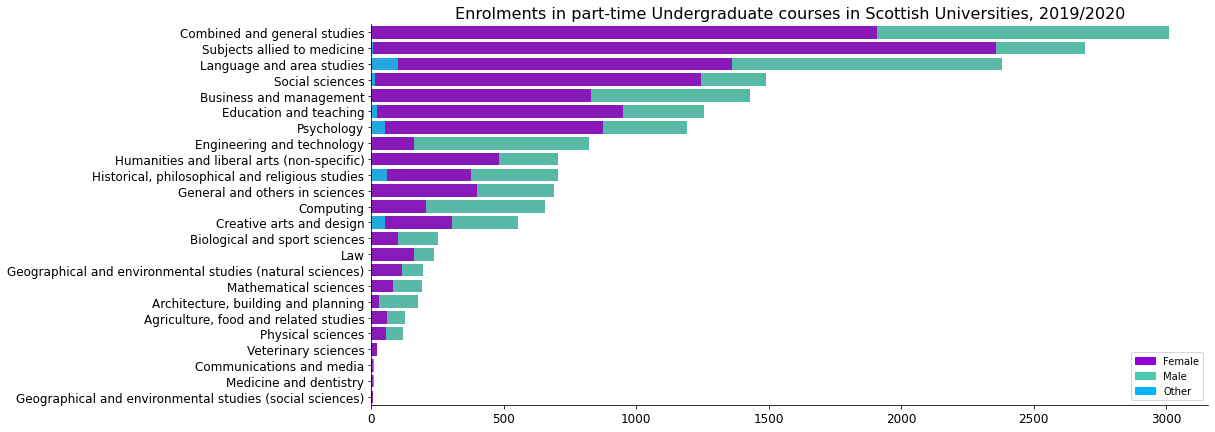

In [17]:
# Get subject list ordered by student enrolment
ug_pt_ix = ug_pt.sort_values(by="Total", ascending = False)["cah_level_1"].unique()

# Plot actual numbers of enrolment
plt.figure(figsize=(15,7))
t = sns.barplot(x="Total", y="cah_level_1", order = ug_pt_ix, palette=[male_color], data=ug_pt)
f = sns.barplot(x="Female", y="cah_level_1", order = ug_pt_ix, palette=[female_color], data=ug_pt)
o = sns.barplot(x="Other", y="cah_level_1", order = ug_pt_ix, palette=[other_color], data=ug_pt)

# add legend
male_bar = mpatches.Patch(color=male_color, label='Male')
female_bar = mpatches.Patch(color=female_color, label='Female')
other_bar = mpatches.Patch(color=other_color, label='Other')
plt.legend(handles=[female_bar, male_bar, other_bar], loc='lower right')

plt.title("Enrolments in part-time Undergraduate courses in Scottish Universities, 2019/2020", size=16)
plt.ylabel("")
plt.xlabel("")
plt.yticks(size=ticks_size)
plt.xticks(size=ticks_size)
sns.despine()
plt.show()

In [18]:
# Filter out "Total" and "Other" in "Sex"
pt_ug_scotland_19_f_m_o = pt_ug_scotland_19[(pt_ug_scotland_19["sex"] != "Total")].copy()

# Calculate percentages of female enrolment per subject
total = pt_ug_scotland_19_f_m_o.groupby('cah_level_1')['number'].sum().reset_index()
female = pt_ug_scotland_19_f_m_o[pt_ug_scotland_19_f_m_o["sex"] =='Female'].groupby('cah_level_1')['number'].sum().reset_index()
other = pt_ug_scotland_19_f_m_o[pt_ug_scotland_19_f_m_o["sex"] == 'Other'].groupby('cah_level_1')['number'].sum().reset_index()

other['number'] = [i / j * 100 for i,j in zip(other['number'], total['number'])]
female['number'] = [i / j * 100 for i,j in zip(female['number'], total['number'])]
total['number'] = [i / j * 100 for i,j in zip(total['number'], total['number'])]
female.sort_values(by="number", ascending=False, inplace=True)
order_ug_pt = female['cah_level_1']

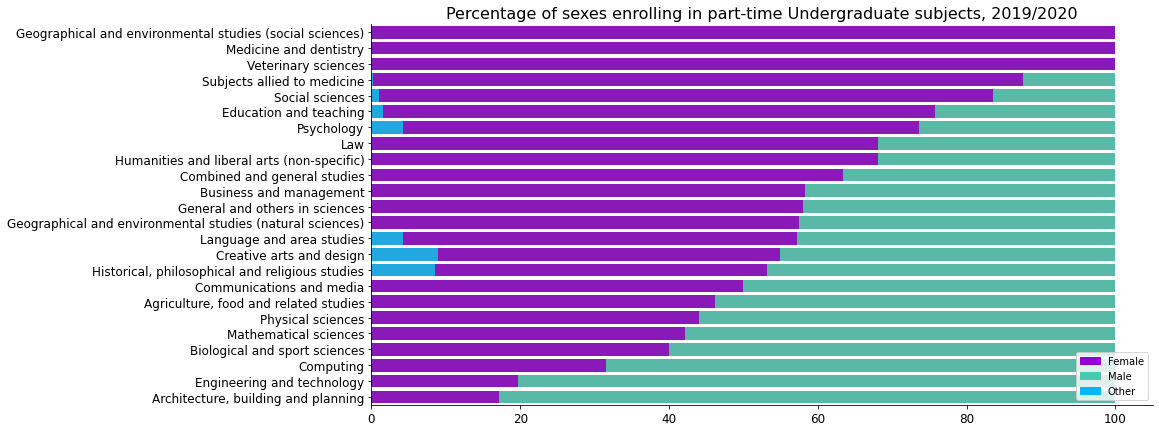

In [19]:
# set the figure size
plt.figure(figsize=(14, 7))

# bar chart 1 -> top bars (group of 'males')
bar1 = sns.barplot(x="number",  y="cah_level_1", order=order_ug_pt, data=total, color=male_color)

# bar chart 2 -> middle bars (group of 'females')
bar2 = sns.barplot(x="number", y="cah_level_1", order=order_ug_pt, data=female, color=female_color)

# bar chart 3 -> bottom bars (group of 'others')
bar3 = sns.barplot(x="number", y="cah_level_1", order=order_ug_pt, data=other, color=other_color)


# add legend
male_bar = mpatches.Patch(color=male_color, label='Male')
female_bar = mpatches.Patch(color=female_color, label='Female')
other_bar = mpatches.Patch(color=other_color, label='Other')
plt.legend(handles=[female_bar, male_bar, other_bar], loc='lower right')

# show the graph
plt.title("Percentage of sexes enrolling in part-time Undergraduate subjects, 2019/2020", size=16)
plt.xlabel("")
plt.xticks(size=ticks_size)
plt.ylabel("")
plt.yticks(size=ticks_size)
sns.despine()
plt.show()

### Analysis

Part-time undergraduate computing courses has the 12th largest student enrolment, with 655 enrolments. 

The percentage of females enrolling in part-time Undergraduate Computing subjects is higher (31.30%) than in full-time Computing courses (18.77%). Despite this, it is third last for female enrolment, ahead of other male-dominated subjects Engineering and technology (19.51%) and Architecture, building and planning (17.14%). 

<hr style="height:2.5px;background-color:darkviolet"></hr>

### Enrolment in full-time postgraduate subjects at Scottish Universities in 2019-2020

In [20]:
# Filter for Scotland, Undergraduate level of study, and full-time study
ft_pg_scotland_19 = df_19_clean[(df_19_clean["first_year_marker"] == "First year")
                     & (df_19_clean["country_of_he_provider"] == "Scotland")
                     & (df_19_clean["level_of_study"] == "All postgraduate")
                     & (df_19_clean["mode_of_study"] == "Full-time")].copy()

In [21]:
# Full time, PG subjects
pg_ft = pd.pivot_table(ft_pg_scotland_19, values="number", index="cah_level_1", columns="sex").reset_index()
pg_ft.sort_values(by="Female", ascending=False, inplace=True)

# Percentage of female
pg_ft["% Female"] = round((pg_ft["Female"] / pg_ft["Total"]) * 100, 2)
pg_ft.sort_values(by="% Female", ascending=False, inplace=True)

# Add color gradient
cm = sns.diverging_palette(20, 235, n=100, center="light", as_cmap=True)
pg_ft.style.background_gradient(cmap=cm, subset=["% Female"])

sex,cah_level_1,Female,Male,Other,Total,% Female
20,Psychology,985,220,5,1210,81.400000
14,Humanities and liberal arts (non-specific),40,10,0,50,80.000000
8,Education and teaching,3265,875,5,4150,78.670000
22,Subjects allied to medicine,1385,450,10,1845,75.070000
5,Communications and media,510,200,5,710,71.830000
12,Geographical and environmental studies (social sciences),125,50,0,175,71.430000
7,Creative arts and design,685,350,10,1040,65.870000
15,Language and area studies,765,390,15,1170,65.380000
16,Law,1235,665,25,1925,64.160000
21,Social sciences,1520,855,15,2390,63.600000


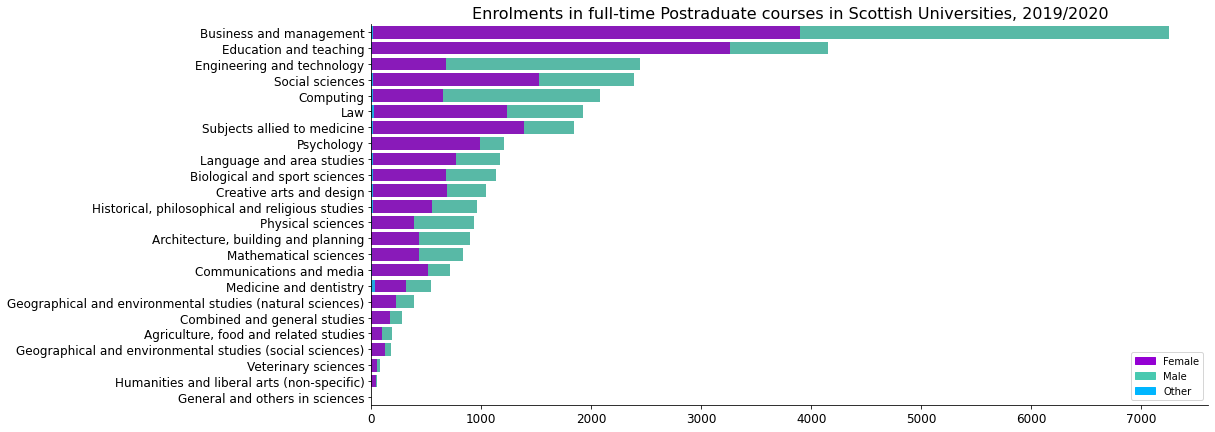

In [22]:
# Get subject list ordered by student enrolment
pg_ft_ix = pg_ft.sort_values(by="Total", ascending = False)["cah_level_1"].unique()

# Plot actual numbers of enrolment
plt.figure(figsize=(15,7))
t = sns.barplot(x="Total", y="cah_level_1", order = pg_ft_ix, palette=[male_color], data=pg_ft)
f = sns.barplot(x="Female", y="cah_level_1", order = pg_ft_ix, palette=[female_color], data=pg_ft)
o = sns.barplot(x="Other", y="cah_level_1", order = pg_ft_ix, palette=[other_color], data=pg_ft)

# add legend
male_bar = mpatches.Patch(color=male_color, label='Male')
female_bar = mpatches.Patch(color=female_color, label='Female')
other_bar = mpatches.Patch(color=other_color, label='Other')
plt.legend(handles=[female_bar, male_bar, other_bar], loc='lower right')

plt.title("Enrolments in full-time Postraduate courses in Scottish Universities, 2019/2020", size=16)
plt.ylabel("")
plt.xlabel("")
plt.yticks(size=ticks_size)
plt.xticks(size=ticks_size)
sns.despine()
plt.show()

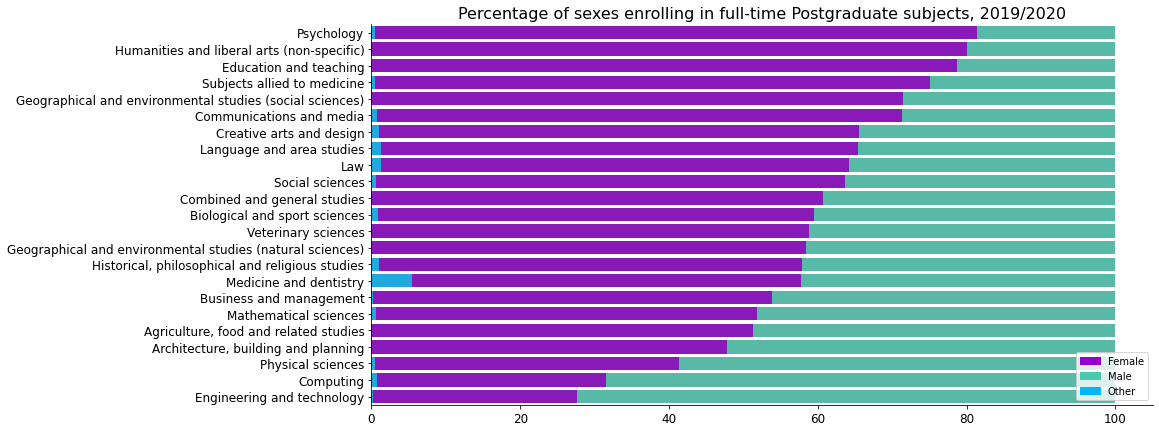

In [23]:
# # Filter out "Total" and "Other" in "Sex"
ft_pg_scotland_19_f_m_o = ft_pg_scotland_19[(ft_pg_scotland_19["sex"] != "Total")].copy()

# Drop rows with 0 
ft_pg_scotland_19_f_m_o_2 = ft_pg_scotland_19_f_m_o[ft_pg_scotland_19_f_m_o['cah_level_1'] != "General and others in sciences"].copy()

# Calculate percentages of female enrolment per subject
total = ft_pg_scotland_19_f_m_o_2.groupby('cah_level_1')['number'].sum().reset_index()
female = ft_pg_scotland_19_f_m_o_2[ft_pg_scotland_19_f_m_o_2["sex"] =='Female'].groupby('cah_level_1')['number'].sum().reset_index()
other = ft_pg_scotland_19_f_m_o_2[ft_pg_scotland_19_f_m_o_2["sex"] == 'Other'].groupby('cah_level_1')['number'].sum().reset_index()

other['number'] = [i / j * 100 for i,j in zip(other['number'], total['number'])]
female['number'] = [i / j * 100 for i,j in zip(female['number'], total['number'])]
total['number'] = [i / j * 100 for i,j in zip(total['number'], total['number'])]

# Get order of subjects by females
female.sort_values(by="number", ascending=False, inplace=True)
order_ft_pg = female["cah_level_1"]


# set the figure size
plt.figure(figsize=(14, 7))

# bar chart 1 -> top bars (group of 'Males')
bar1 = sns.barplot(x="number",  y="cah_level_1", order=order_ft_pg, data=total, color=male_color)

# bar chart 2 -> middle bars (group of 'Females')
bar2 = sns.barplot(x="number", y="cah_level_1", order=order_ft_pg, data=female, color=female_color)

# bar chart 3 -> bottom bars (group of 'Other')
bar3 = sns.barplot(x="number", y="cah_level_1", order=order_ft_pg, data=other, color=other_color)

# add legend
male_bar = mpatches.Patch(color=male_color, label='Male')
female_bar = mpatches.Patch(color=female_color, label='Female')
other_bar = mpatches.Patch(color=other_color, label='Other')
plt.legend(handles=[female_bar, male_bar, other_bar], loc='lower right')

# show the graph
plt.title("Percentage of sexes enrolling in full-time Postgraduate subjects, 2019/2020", size=16)
plt.xlabel("")
plt.xticks(size=ticks_size)
plt.ylabel("")
plt.yticks(size=ticks_size)
sns.despine()
plt.show()

### Analysis

Enrolment in full-time postgraduate computing courses is high, with the subject having the fifth largest enrolment. This was the same for full-time undergraduate computing courses.

Despite this, the percentage of females enrolling computing courses is one of the lowest (31.57%), ahead of only Engineering and technology (27.66%). 

The percentage of females enrolling in full-time postgraduate Computing courses is higher than the percentage of females enrolling in full-time undergraduate Computing courses (18.77% vs 31.57%).

<hr style="height:2.5px;background-color:darkviolet"></hr>

### Enrolment in part-time postgraduate subjects at Scottish Universities in 2019-2020

In [24]:
# Filter for Scotland, Undergraduate level of study, and full-time study
pt_pg_scotland_19 = df_19_clean[(df_19_clean["first_year_marker"] == "First year")
                     & (df_19_clean["country_of_he_provider"] == "Scotland")
                     & (df_19_clean["level_of_study"] == "All postgraduate")
                     & (df_19_clean["mode_of_study"] == "Part-time")].copy()

In [25]:
# Full time, UG subjects
pg_pt = pd.pivot_table(pt_pg_scotland_19, values="number", index="cah_level_1", columns="sex").reset_index()

# Percentage of female
pg_pt["% Female"] = round((pg_pt["Female"] / pg_pt["Total"]) * 100, 2)
pg_pt.sort_values(by="% Female", ascending=False, inplace=True)

# # Add color gradient
cm = sns.diverging_palette(20, 235, n=100, center="light", as_cmap=True)
pg_pt.style.background_gradient(cmap=cm, subset=["% Female"])

sex,cah_level_1,Female,Male,Other,Total,% Female
12,Geographical and environmental studies (social sciences),10,5,0,10,100.000000
10,General and others in sciences,5,5,0,5,100.000000
23,Veterinary sciences,50,10,0,60,83.330000
22,Subjects allied to medicine,2250,465,5,2725,82.570000
21,Social sciences,735,235,5,975,75.380000
8,Education and teaching,1630,735,10,2375,68.630000
18,Medicine and dentistry,395,180,10,580,68.100000
2,Biological and sport sciences,305,145,0,450,67.780000
0,"Agriculture, food and related studies",105,50,0,155,67.740000
15,Language and area studies,125,60,5,190,65.790000


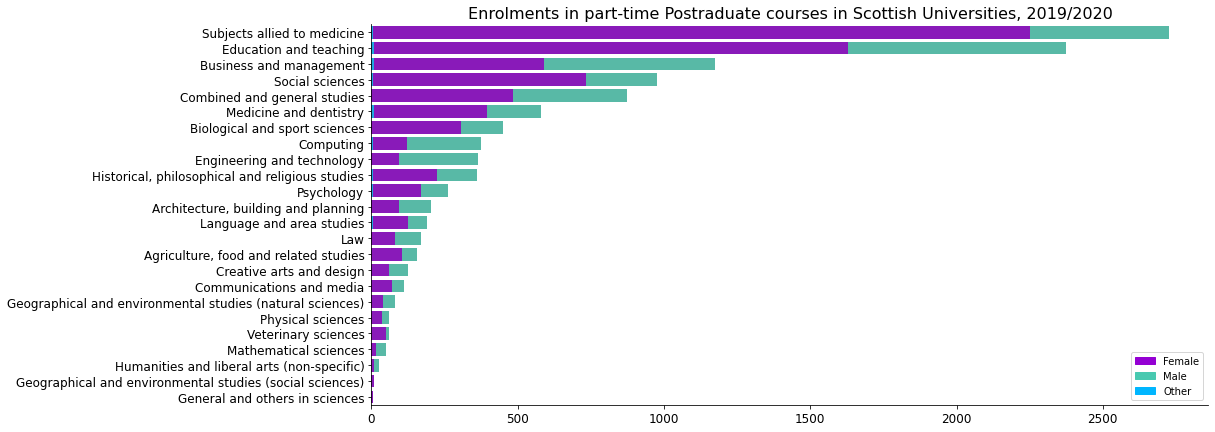

In [26]:
# Get subject list ordered by student enrolment
pg_pt_ix = pg_pt.sort_values(by="Total", ascending = False)["cah_level_1"].unique()

# Plot actual numbers of enrolment
plt.figure(figsize=(15,7))
t = sns.barplot(x="Total", y="cah_level_1", order = pg_pt_ix, palette=[male_color], data=pg_pt)
f = sns.barplot(x="Female", y="cah_level_1", order = pg_pt_ix, palette=[female_color], data=pg_pt)
o = sns.barplot(x="Other", y="cah_level_1", order = pg_pt_ix, palette=[other_color], data=pg_pt)

# add legend
male_bar = mpatches.Patch(color=male_color, label='Male')
female_bar = mpatches.Patch(color=female_color, label='Female')
other_bar = mpatches.Patch(color=other_color, label='Other')
plt.legend(handles=[female_bar, male_bar, other_bar], loc='lower right')

plt.title("Enrolments in part-time Postraduate courses in Scottish Universities, 2019/2020", size=16)
plt.ylabel("")
plt.xlabel("")
plt.yticks(size=ticks_size)
plt.xticks(size=ticks_size)
sns.despine()
plt.show()

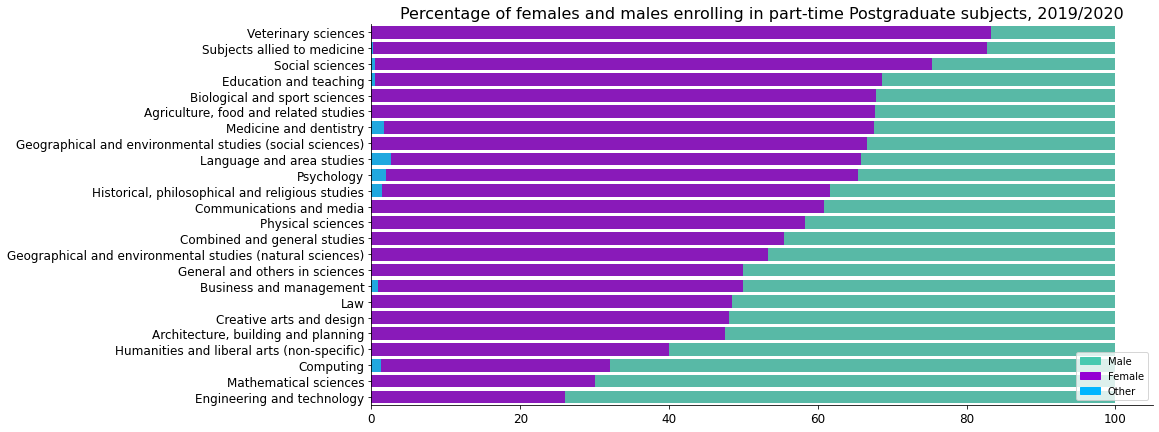

In [27]:
# Filter out "Total"
pt_pg_scotland_19_f_m_o = pt_pg_scotland_19[(pt_pg_scotland_19["sex"] != "Total")].copy()

# Calculate percentages of female enrolment per subject
total = pt_pg_scotland_19_f_m_o.groupby('cah_level_1')['number'].sum().reset_index()
female = pt_pg_scotland_19_f_m_o[pt_pg_scotland_19_f_m_o["sex"] =='Female'].groupby('cah_level_1')['number'].sum().reset_index()
other = pt_pg_scotland_19_f_m_o[pt_pg_scotland_19_f_m_o["sex"] == 'Other'].groupby('cah_level_1')['number'].sum().reset_index()

other['number'] = [i / j * 100 for i,j in zip(other['number'], total['number'])]
female['number'] = [i / j * 100 for i,j in zip(female['number'], total['number'])]
total['number'] = [i / j * 100 for i,j in zip(total['number'], total['number'])]
female.sort_values(by="number", ascending=False, inplace=True)
order_pt_pg = female["cah_level_1"]

# set the figure size
plt.figure(figsize=(14, 7))

# bar chart 1 -> top bars (group of 'Males')
bar1 = sns.barplot(x="number",  y="cah_level_1", order=order_pt_pg, data=total, color=male_color)

# bar chart 2 -> bottom bars (group of 'Females')
bar2 = sns.barplot(x="number", y="cah_level_1", order=order_pt_pg, data=female, color=female_color)

# bar chart 3 -> bottom bars (group of 'Other')
bar3 = sns.barplot(x="number", y="cah_level_1", order=order_pt_pg, data=other, color=other_color)


# add legend
male_bar = mpatches.Patch(color=male_color, label='Male')
female_bar = mpatches.Patch(color=female_color, label='Female')
other_bar = mpatches.Patch(color=other_color, label='Other')
plt.legend(handles=[male_bar, female_bar, other_bar], loc='lower right')

# show the graph
plt.title("Percentage of females and males enrolling in part-time Postgraduate subjects, 2019/2020", size=16)
plt.xlabel("")
plt.xticks(size=ticks_size)
plt.ylabel("")
plt.yticks(size=ticks_size)
sns.despine()
plt.show()

### Analysis

Computing has the 8th largest student enrolment at part-time Postgraduate level.

Similar to part-time UG and full-time PG, enrolment in part-time postgraduate Computing courses is made up of 32% of females.

<hr style="height:2.5px;background-color:darkviolet"></hr>

## Issues and Further Questions

One issue with the above is we don't know where students studying at Scottish Universities are from i.e. whether they are Scottish or from the rest of the UK or International. It would be useful to know what proportion of students are Scottish/UK/International, to see whether this affected the number of females studying Computing and other STEM subjects.